# California Housing Regression Machine Learning

In [1]:
import pandas as pd
import numpy as np
from numpy import mean
import lightgbm as lgb
from lightgbm import LGBMRegressor
from verstack import LGBMTuner
from matplotlib import pyplot as plt
from sklearn.preprocessing import PowerTransformer,StandardScaler
from sklearn.ensemble import IsolationForest
from sklearn.datasets import fetch_california_housing

Read input data

In [2]:
train = pd.read_csv(r'./input_data/train.csv')
test = pd.read_csv(r'./input_data/test.csv')

In [3]:
House_sklearn, y = fetch_california_housing(return_X_y=True)
House_sklearn = pd.DataFrame(House_sklearn, columns=train.columns[1:-1])
House_sklearn['MedHouseVal'] = y

Preprocessing training data

In [4]:
train.drop(['id'],axis=1,inplace=True)
Train = pd.concat([train,House_sklearn],axis=0).reset_index(drop=True)
Train.to_csv(r"train_extended.csv")

In [7]:
clf = IsolationForest(contamination =0.05,max_samples=0.7 ,random_state=0).fit(Train)
OD = clf.predict(Train.values)
Outlier_rows = []
for i in range(Train.shape[0]):
    
    if OD[i] == -1:
        Outlier_rows.append(i)
Train = Train.drop(Outlier_rows)
Train = Train.reset_index(drop=True)

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,2.3859,15.0,3.827160,1.112100,1280.0,2.486989,34.60,-120.12,0.980
1,3.7188,17.0,6.013373,1.054217,1504.0,3.813084,38.69,-121.22,0.946
2,4.7750,27.0,6.535604,1.103175,1061.0,2.464602,34.71,-120.45,1.576
3,2.4138,16.0,3.350203,0.965432,1255.0,2.089286,32.66,-117.09,1.336
4,3.7500,52.0,4.284404,1.069246,1793.0,1.604790,37.80,-122.41,4.500
...,...,...,...,...,...,...,...,...,...
54883,1.5603,25.0,5.045455,1.133333,845.0,2.560606,39.48,-121.09,0.781
54884,2.5568,18.0,6.114035,1.315789,356.0,3.122807,39.49,-121.21,0.771
54885,1.7000,17.0,5.205543,1.120092,1007.0,2.325635,39.43,-121.22,0.923
54886,1.8672,18.0,5.329513,1.171920,741.0,2.123209,39.43,-121.32,0.847


Preprocessing test data

In [8]:
test.drop(['id'],axis=1,inplace=True)
All = pd.concat([Train,test],axis=0).reset_index(drop=True)

# These 4 columns do not have completely gaussian distribution 
#need_scale = ['Population','AveOccup','Latitude','Longitude']
#All[need_scale] = StandardScaler().fit_transform(All[need_scale])
All

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,2.3859,15.0,3.827160,1.112100,1280.0,2.486989,34.60,-120.12,0.980
1,3.7188,17.0,6.013373,1.054217,1504.0,3.813084,38.69,-121.22,0.946
2,4.7750,27.0,6.535604,1.103175,1061.0,2.464602,34.71,-120.45,1.576
3,2.4138,16.0,3.350203,0.965432,1255.0,2.089286,32.66,-117.09,1.336
4,3.7500,52.0,4.284404,1.069246,1793.0,1.604790,37.80,-122.41,4.500
...,...,...,...,...,...,...,...,...,...
79642,2.2875,34.0,3.914729,1.085271,866.0,2.071429,34.44,-119.75,NaN
79643,3.0781,33.0,4.771971,1.038674,1628.0,2.326848,34.09,-117.96,NaN
79644,2.6961,14.0,4.593960,1.170380,3900.0,2.540034,37.51,-120.83,NaN
79645,7.2315,8.0,7.508403,1.018692,1388.0,2.601202,33.67,-117.98,NaN


### LGBMTuner

This module tune the model automatically. For getting Stable prediction, we run the LGBMTuner multiple times and return their mean as the final prediction.


In [9]:
def stable_prediction(n_trials):
    
    predictions = pd.DataFrame(columns = [i for i in range(n_trials)])
    
    for trial in range(n_trials):
        
        train_prepared = All.head(Train.shape[0])
        test_prepared = All.tail(test.shape[0])

        X = train_prepared.values[:,:-1]
        Y = train_prepared.values[:,-1]
        
        # the only required argument
        tuner = LGBMTuner(metric = 'rmse',trials = 150,seed = 13) 

        #the tuner needs these datatype for X and Y
        X = pd.DataFrame(X)
        Y = pd.Series(Y)
        tuner.fit(X,Y)
        test_df = pd.DataFrame(test_prepared.values[:,:-1])
        predicted = tuner.predict(test_df)

        predictions[trial] = predicted
        
    Mean_Prediction = []
    
    for i in range(predictions.shape[0]):
        
        row = predictions.iloc[i].values.tolist()
        Mean = mean(row)
        Mean_Prediction.append(Mean)
    
    return Mean_Prediction,predictions


 * Initiating LGBMTuner.fit
     . Settings:
     .. Trying 150 trials
     .. Evaluation metric: rmse 
     .. Study direction: minimize rmse

     . Trial number: 0 finished
     .. Optimization score (lower-better): rmse: 0.5013096521870921
 ...........................................................................
     . Trial number: 1 finished
     .. Optimization score (lower-better): rmse: 0.49632327240820373
 ...........................................................................
     . Trial number: 2 finished
     .. Optimization score (lower-better): rmse: 0.5002783187093706
 ...........................................................................
     . Trial number: 3 finished
     .. Optimization score (lower-better): rmse: 0.49627066782202806
 ...........................................................................
     . Trial number: 4 finished
     .. Optimization score (lower-better): rmse: 0.502080687875573
 .............................................

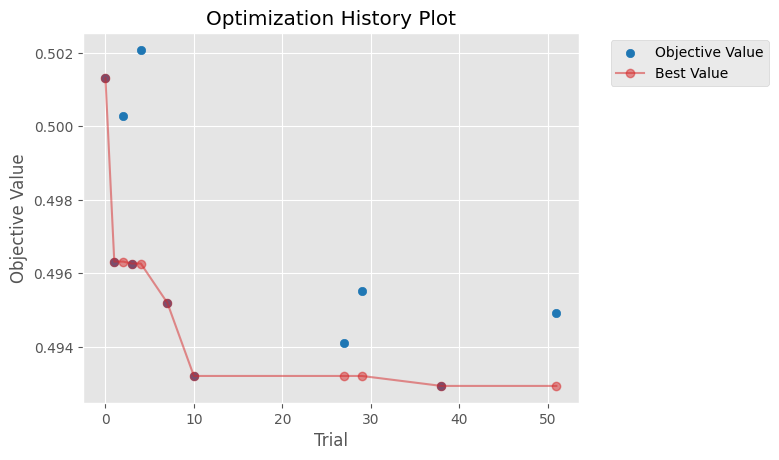

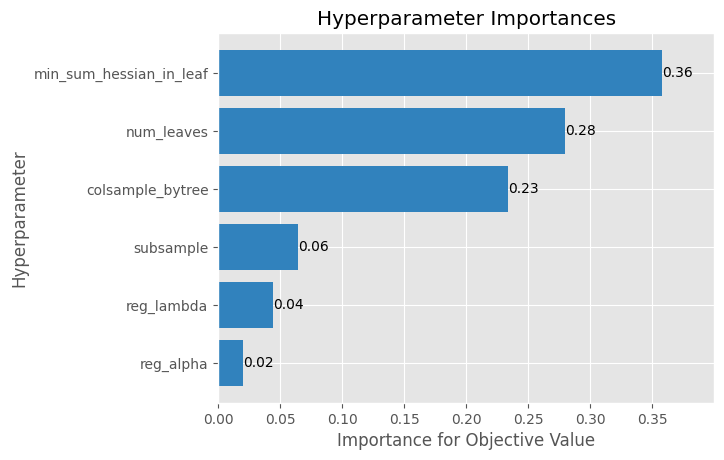

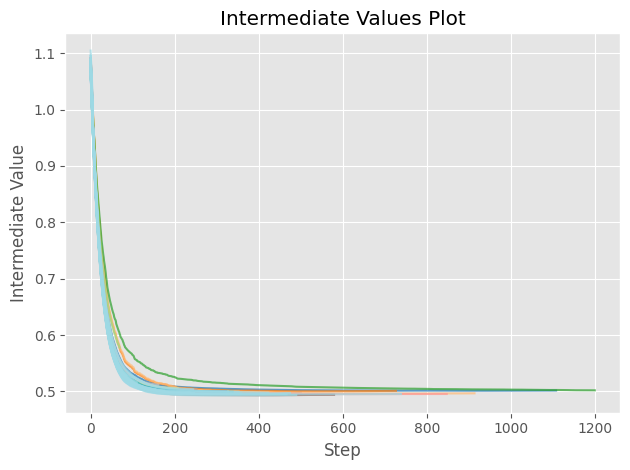

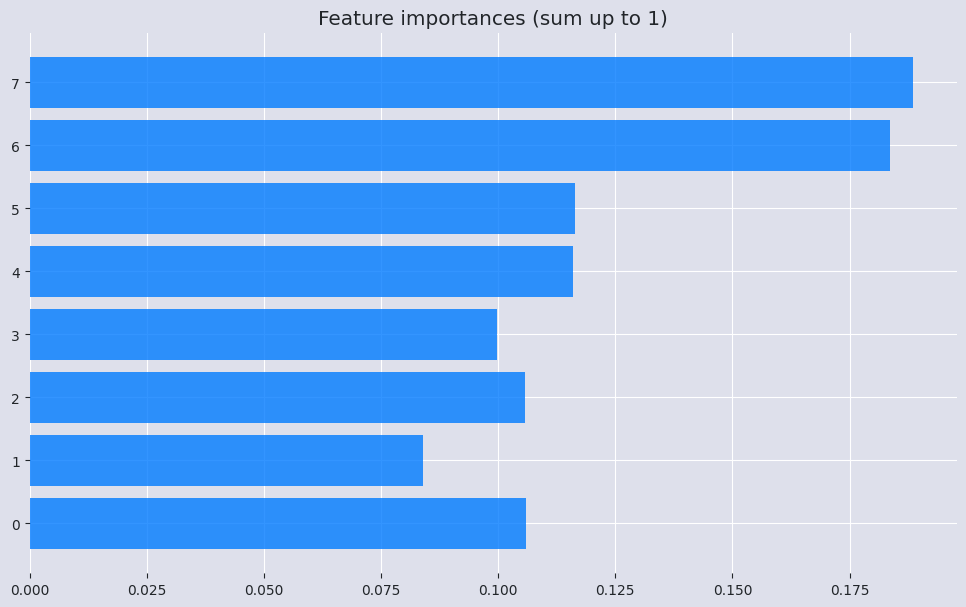


     . Optuna hyperparameters optimization finished
     .. Best trial number:38    |     rmse:           0.4929415407606448
 ---------------------------------------------------------------------------
     . n_estimators optimization finished
     .. best iteration:  322   |     rmse:           0.4990764485599083

Time elapsed for fit execution: 1 min 29.471 sec

 * Initiating LGBMTuner.fit
     . Settings:
     .. Trying 150 trials
     .. Evaluation metric: rmse 
     .. Study direction: minimize rmse

     . Trial number: 0 finished
     .. Optimization score (lower-better): rmse: 0.4941146285635619
 ...........................................................................
     . Trial number: 1 finished
     .. Optimization score (lower-better): rmse: 0.5034087309287519
 ...........................................................................
     . Trial number: 2 finished
     .. Optimization score (lower-better): rmse: 0.5024588391953545
 .................................

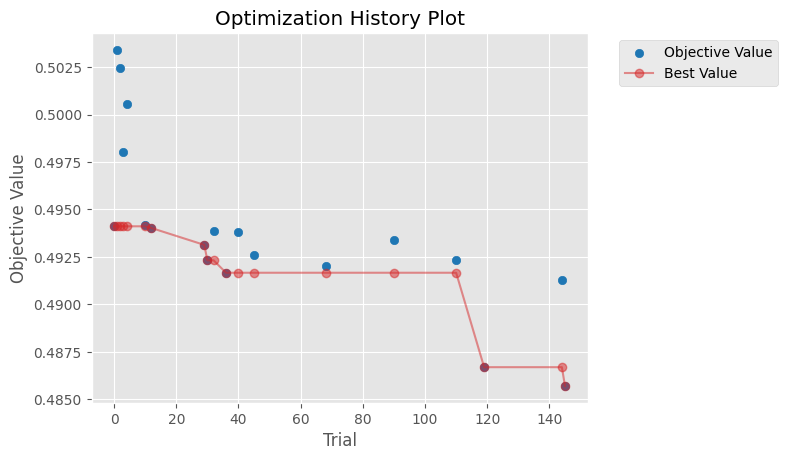

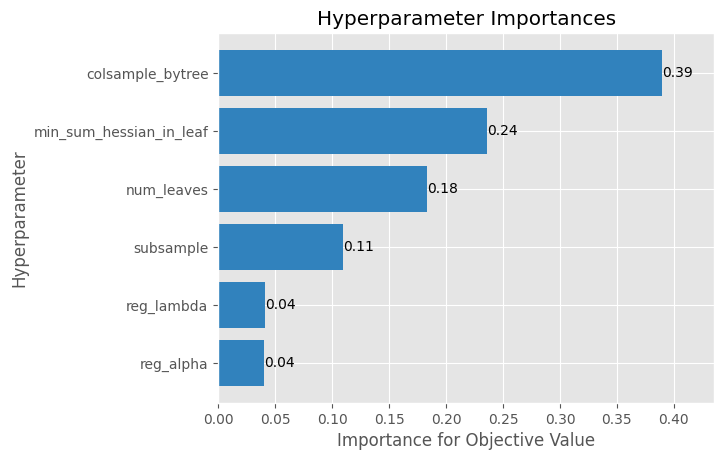

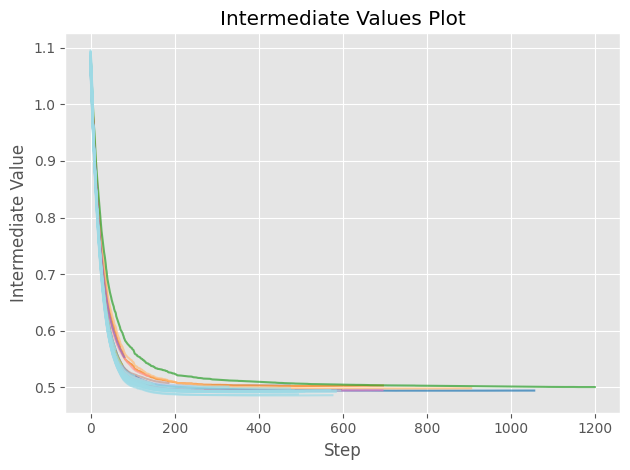

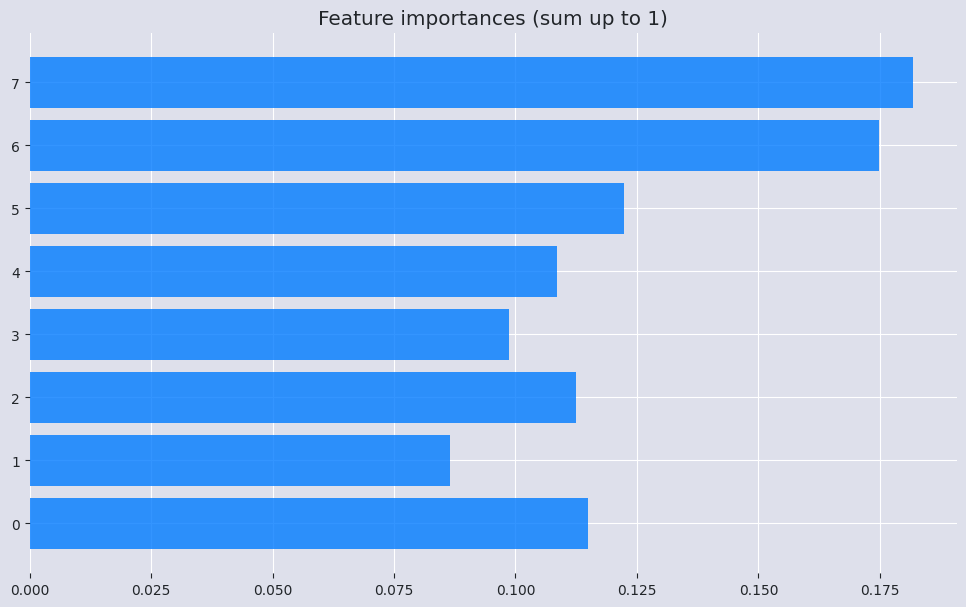


     . Optuna hyperparameters optimization finished
     .. Best trial number:145    |     rmse:            0.485703173693775
 ---------------------------------------------------------------------------
     . n_estimators optimization finished
     .. best iteration:  388   |     rmse:          0.49452579971394606

Time elapsed for fit execution: 1 min 46.108 sec

 * Initiating LGBMTuner.fit
     . Settings:
     .. Trying 150 trials
     .. Evaluation metric: rmse 
     .. Study direction: minimize rmse

     . Trial number: 0 finished
     .. Optimization score (lower-better): rmse: 0.49380717114625367
 ...........................................................................
     . Trial number: 1 finished
     .. Optimization score (lower-better): rmse: 0.501211648401862
 ...........................................................................
     . Trial number: 2 finished
     .. Optimization score (lower-better): rmse: 0.49653551368801696
 ...............................

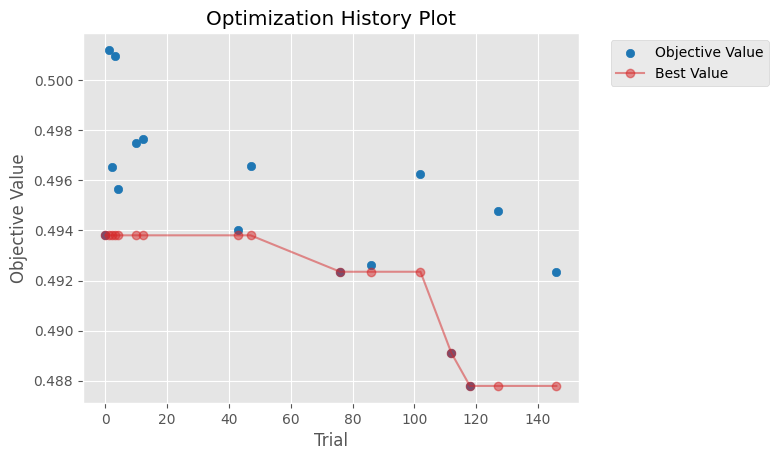

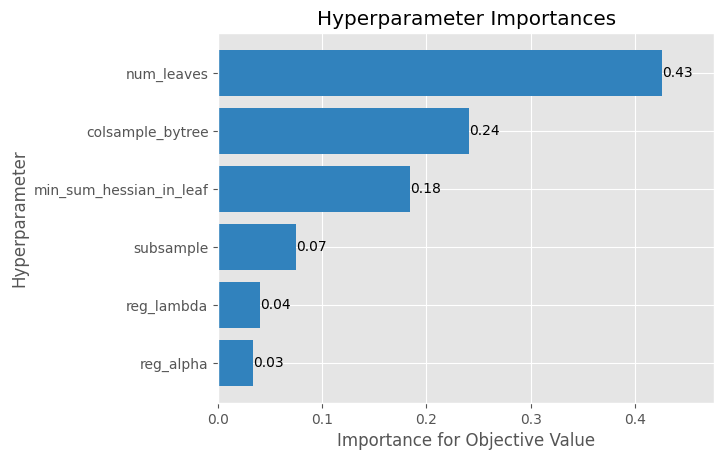

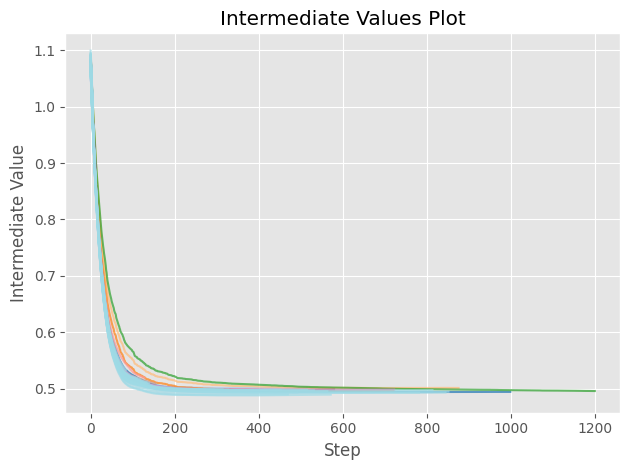

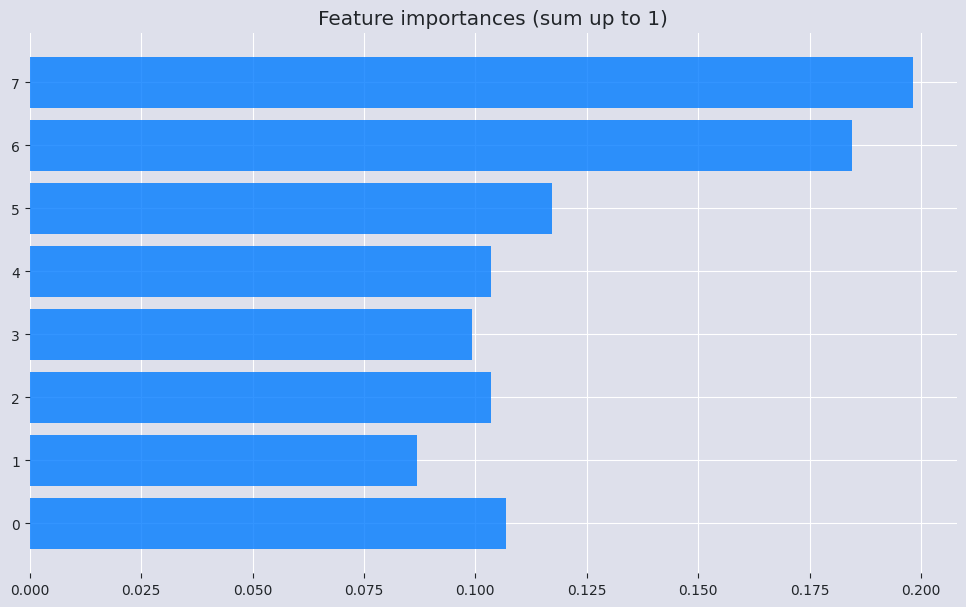


     . Optuna hyperparameters optimization finished
     .. Best trial number:118    |     rmse:          0.48779272642714017
 ---------------------------------------------------------------------------
     . n_estimators optimization finished
     .. best iteration:  238   |     rmse:           0.4948633664061089

Time elapsed for fit execution: 1 min 38.462 sec

 * Initiating LGBMTuner.fit
     . Settings:
     .. Trying 150 trials
     .. Evaluation metric: rmse 
     .. Study direction: minimize rmse

     . Trial number: 0 finished
     .. Optimization score (lower-better): rmse: 0.4943773556407916
 ...........................................................................
     . Trial number: 1 finished
     .. Optimization score (lower-better): rmse: 0.4958401678269249
 ...........................................................................
     . Trial number: 2 finished
     .. Optimization score (lower-better): rmse: 0.4935635349417507
 ................................

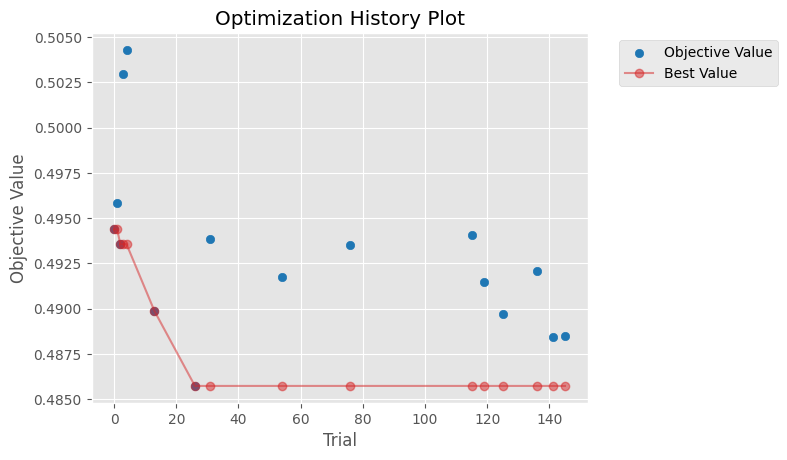

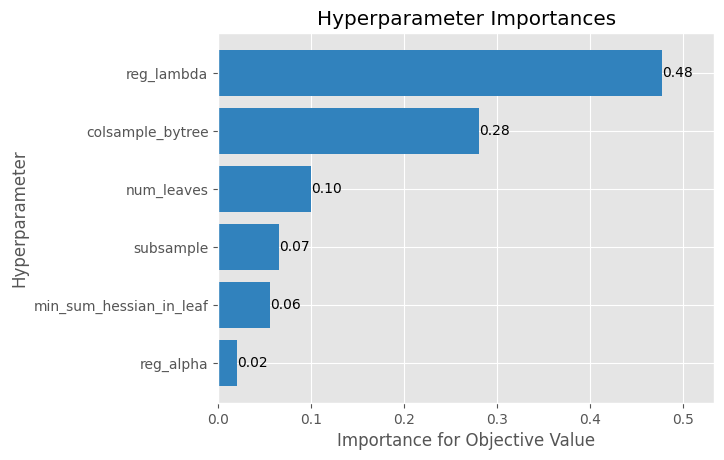

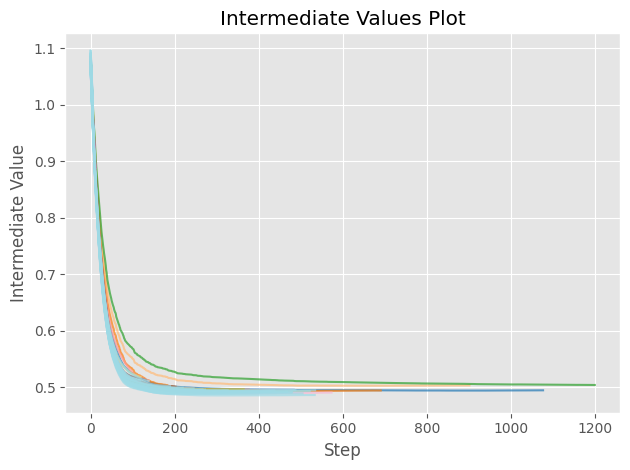

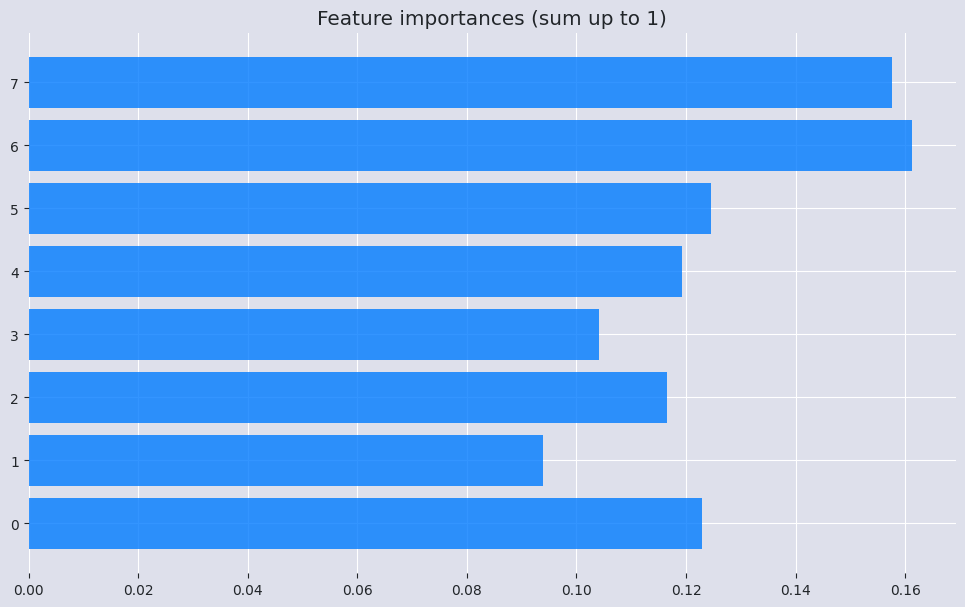


     . Optuna hyperparameters optimization finished
     .. Best trial number:26    |     rmse:           0.4857302431657032
 ---------------------------------------------------------------------------
     . n_estimators optimization finished
     .. best iteration:  358   |     rmse:           0.4940025110689747

Time elapsed for fit execution: 1 min 48.404 sec

 * Initiating LGBMTuner.fit
     . Settings:
     .. Trying 150 trials
     .. Evaluation metric: rmse 
     .. Study direction: minimize rmse

     . Trial number: 0 finished
     .. Optimization score (lower-better): rmse: 0.5011943958546041
 ...........................................................................
     . Trial number: 1 finished
     .. Optimization score (lower-better): rmse: 0.49406871660766366
 ...........................................................................
     . Trial number: 2 finished
     .. Optimization score (lower-better): rmse: 0.5050187816913253
 ................................

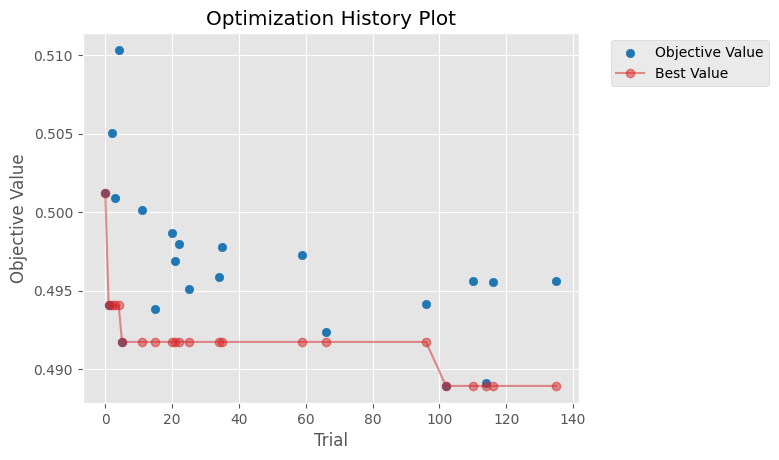

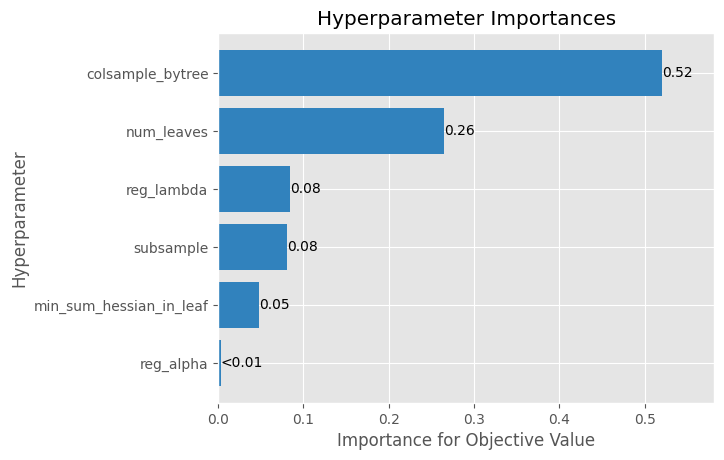

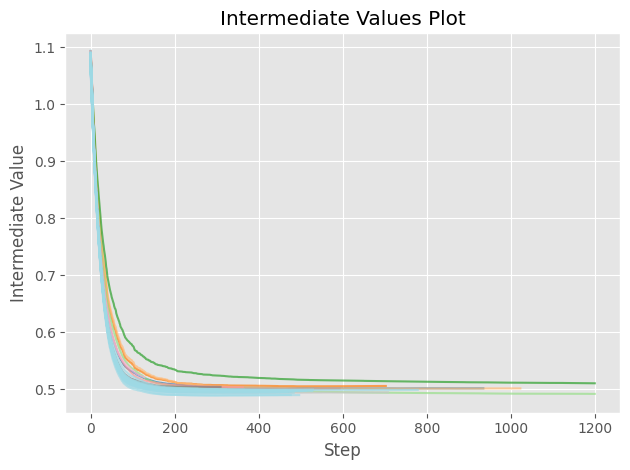

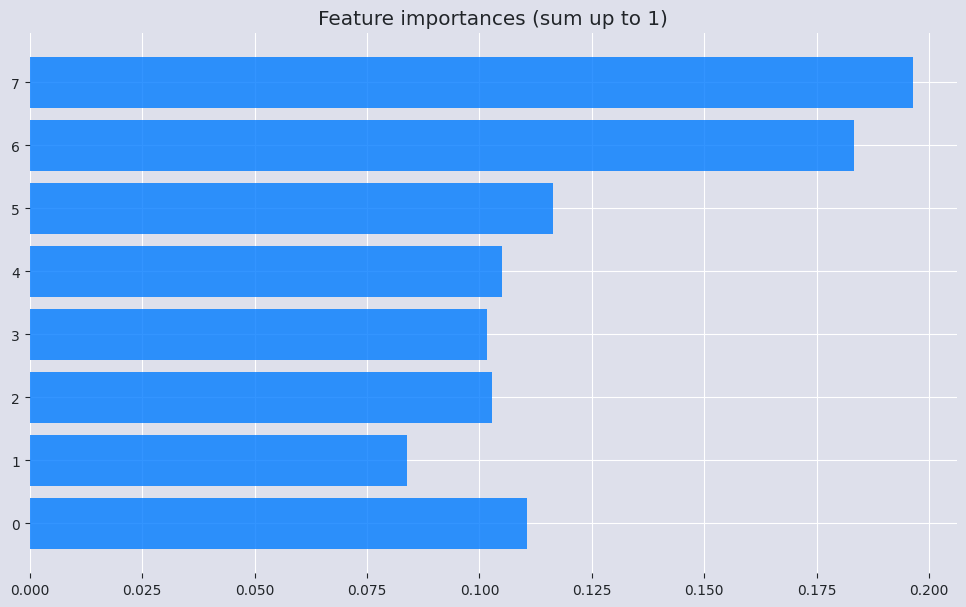


     . Optuna hyperparameters optimization finished
     .. Best trial number:102    |     rmse:           0.4889479572518378
 ---------------------------------------------------------------------------
     . n_estimators optimization finished
     .. best iteration:  270   |     rmse:          0.49526078656917916

Time elapsed for fit execution: 2 min 6.173 sec

 * Initiating LGBMTuner.fit
     . Settings:
     .. Trying 150 trials
     .. Evaluation metric: rmse 
     .. Study direction: minimize rmse

     . Trial number: 0 finished
     .. Optimization score (lower-better): rmse: 0.4962397700157456
 ...........................................................................
     . Trial number: 1 finished
     .. Optimization score (lower-better): rmse: 0.4953161780690869
 ...........................................................................
     . Trial number: 2 finished
     .. Optimization score (lower-better): rmse: 0.5053216366821487
 .................................

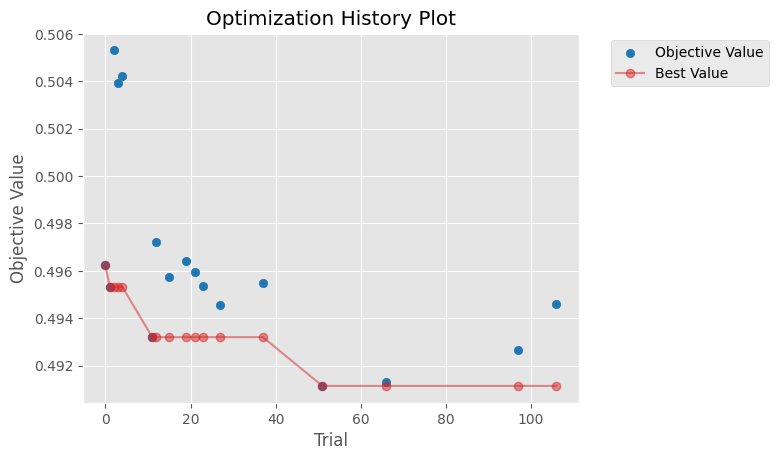

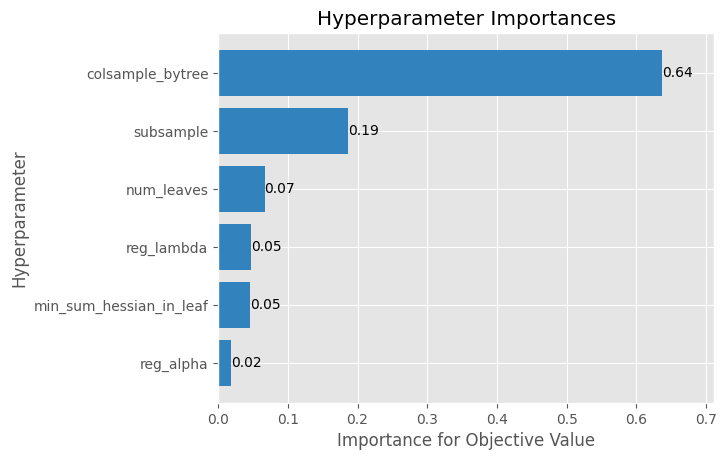

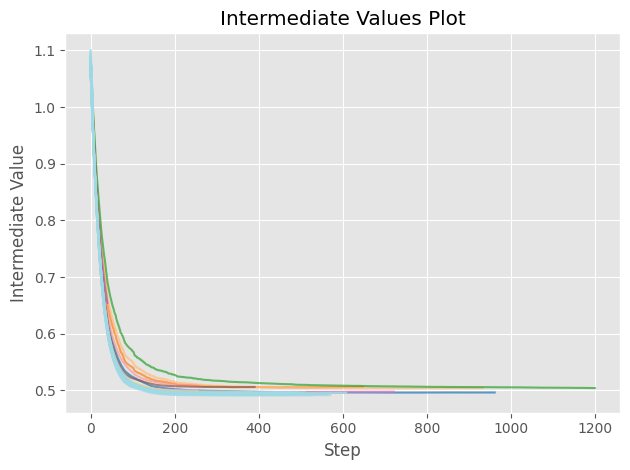

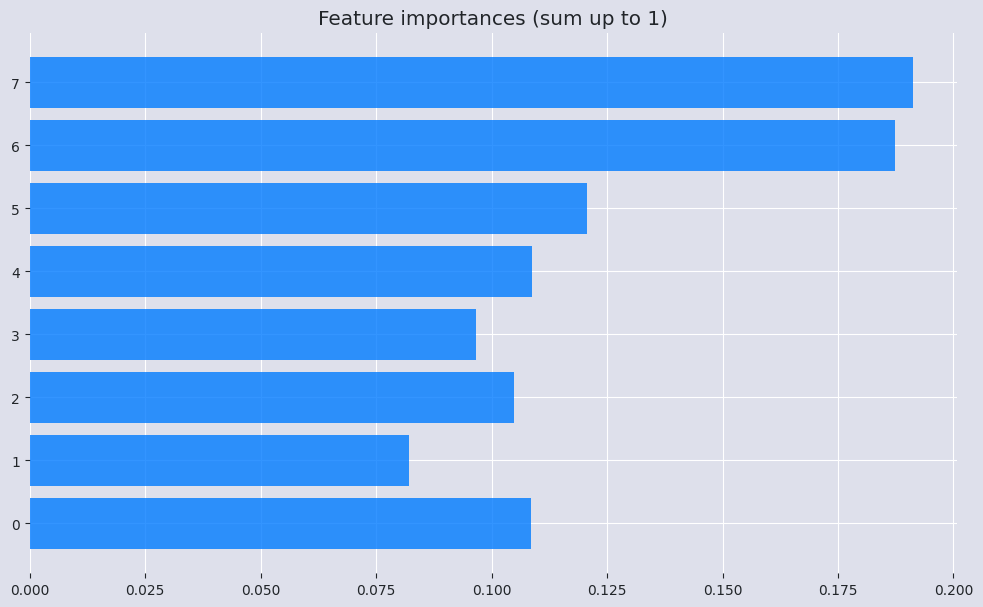


     . Optuna hyperparameters optimization finished
     .. Best trial number:51    |     rmse:           0.4911483692320336
 ---------------------------------------------------------------------------
     . n_estimators optimization finished
     .. best iteration:  316   |     rmse:           0.4978935464949101

Time elapsed for fit execution: 1 min 37.571 sec

 * Initiating LGBMTuner.fit
     . Settings:
     .. Trying 150 trials
     .. Evaluation metric: rmse 
     .. Study direction: minimize rmse

     . Trial number: 0 finished
     .. Optimization score (lower-better): rmse: 0.4966439590657038
 ...........................................................................
     . Trial number: 1 finished
     .. Optimization score (lower-better): rmse: 0.4999370310215739
 ...........................................................................
     . Trial number: 2 finished
     .. Optimization score (lower-better): rmse: 0.5019406153276137
 .................................

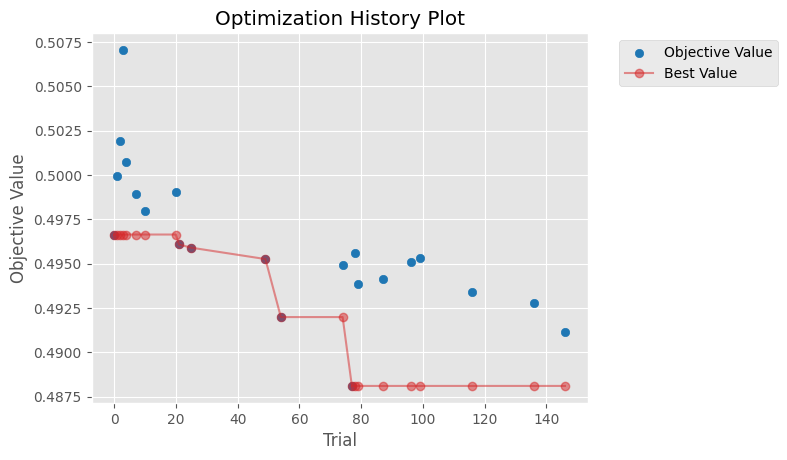

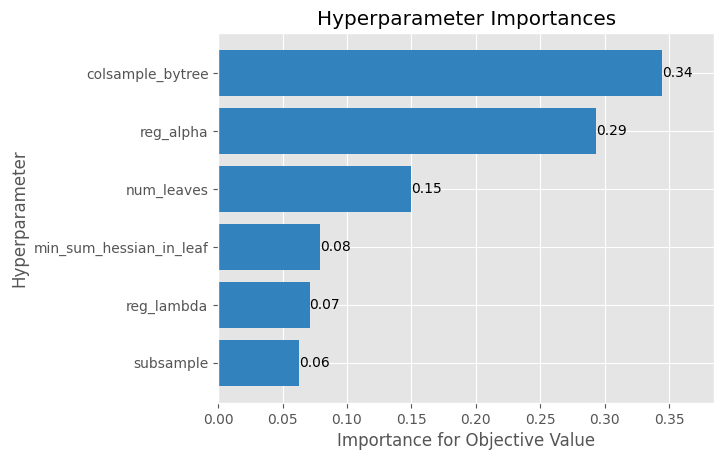

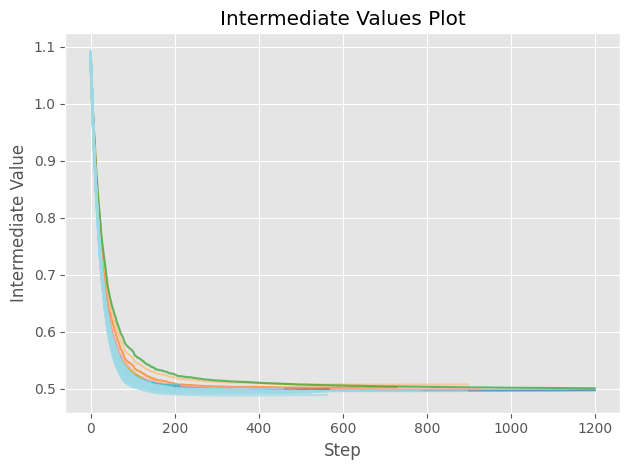

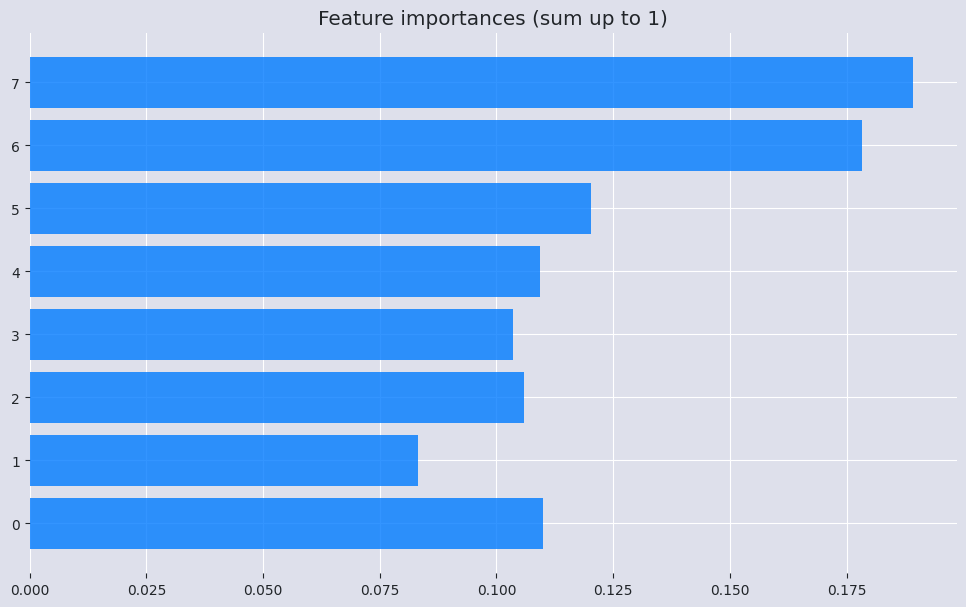


     . Optuna hyperparameters optimization finished
     .. Best trial number:77    |     rmse:           0.4881109281588129
 ---------------------------------------------------------------------------
     . n_estimators optimization finished
     .. best iteration:  283   |     rmse:           0.4949913507063983

Time elapsed for fit execution: 2 min 7.689 sec

 * Initiating LGBMTuner.fit
     . Settings:
     .. Trying 150 trials
     .. Evaluation metric: rmse 
     .. Study direction: minimize rmse

     . Trial number: 0 finished
     .. Optimization score (lower-better): rmse: 0.49808165096295665
 ...........................................................................
     . Trial number: 1 finished
     .. Optimization score (lower-better): rmse: 0.4928357445897041
 ...........................................................................
     . Trial number: 2 finished
     .. Optimization score (lower-better): rmse: 0.5110974762038234
 .................................

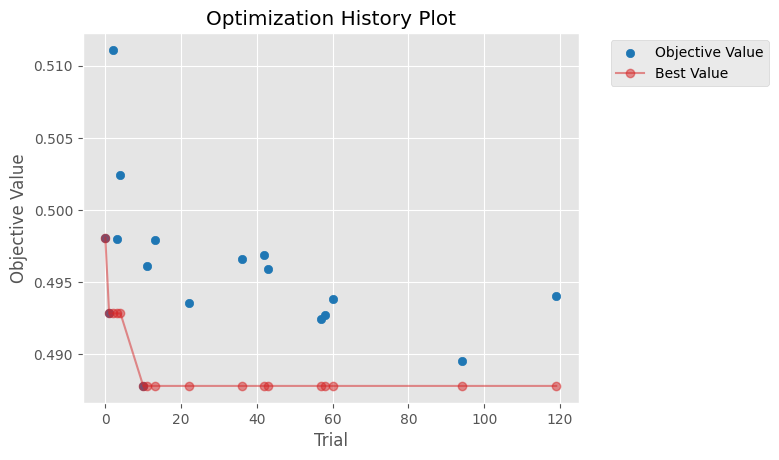

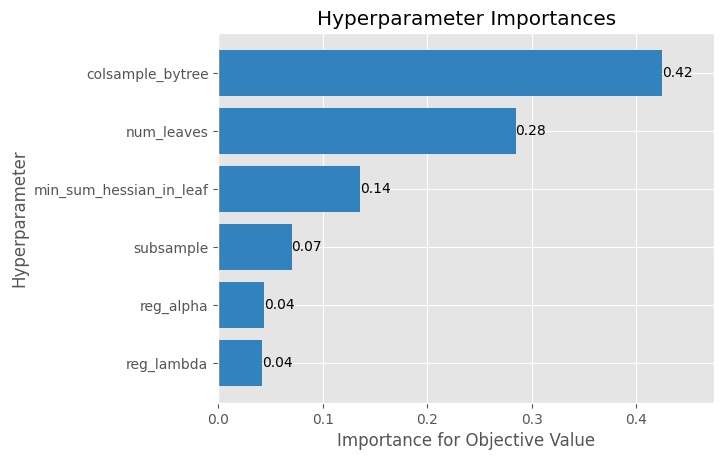

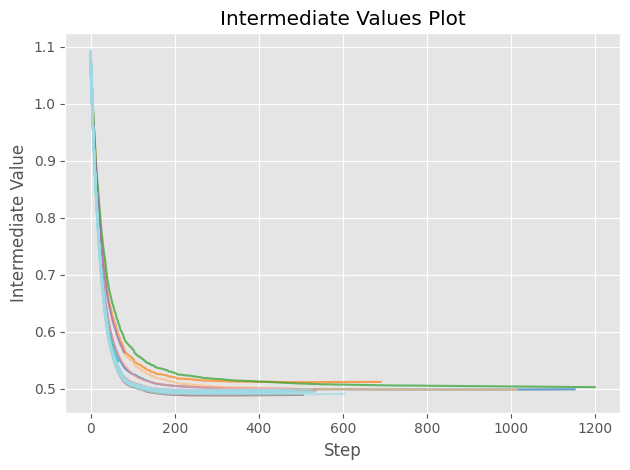

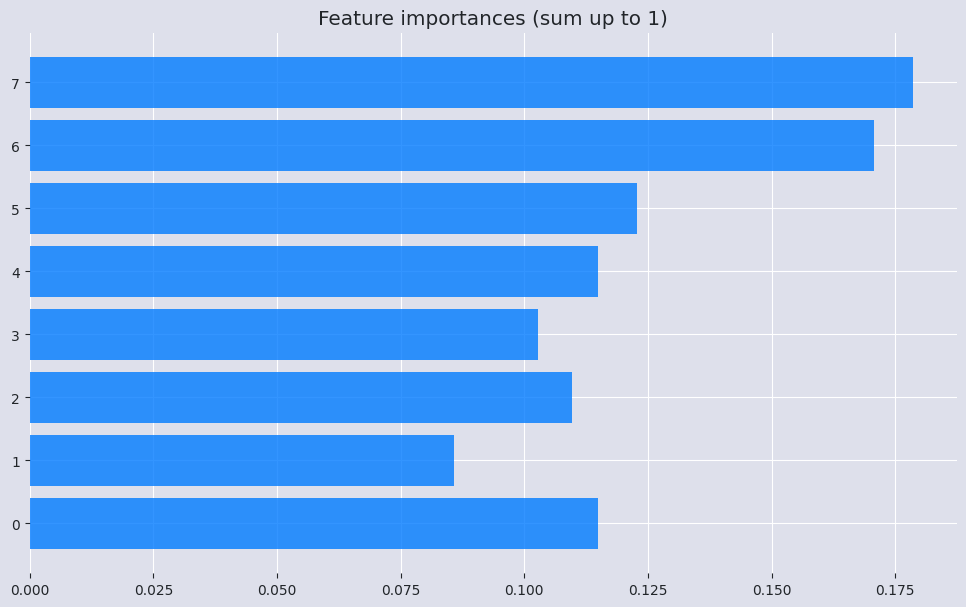


     . Optuna hyperparameters optimization finished
     .. Best trial number:10    |     rmse:          0.48780898216178936
 ---------------------------------------------------------------------------
     . n_estimators optimization finished
     .. best iteration:  331   |     rmse:           0.4950679009286657

Time elapsed for fit execution: 1 min 29.627 sec

 * Initiating LGBMTuner.fit
     . Settings:
     .. Trying 150 trials
     .. Evaluation metric: rmse 
     .. Study direction: minimize rmse

     . Trial number: 0 finished
     .. Optimization score (lower-better): rmse: 0.5046560447344518
 ...........................................................................
     . Trial number: 1 finished
     .. Optimization score (lower-better): rmse: 0.4977975134335664
 ...........................................................................
     . Trial number: 2 finished
     .. Optimization score (lower-better): rmse: 0.5013216630747193
 .................................

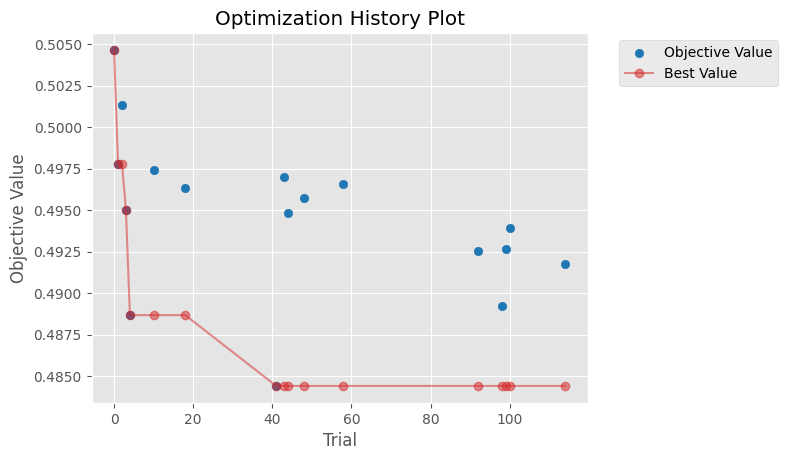

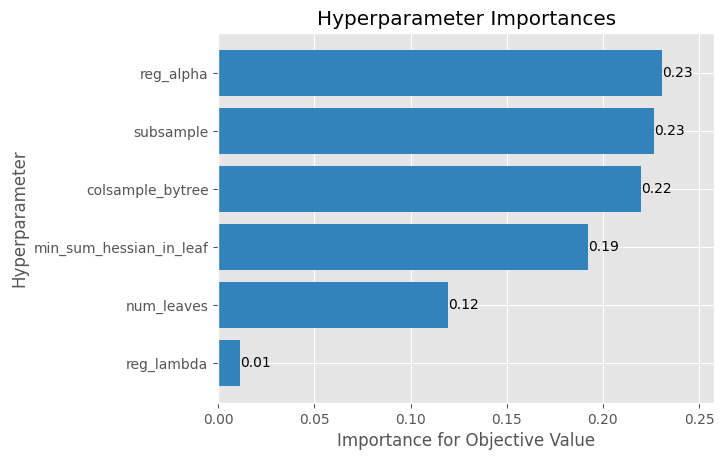

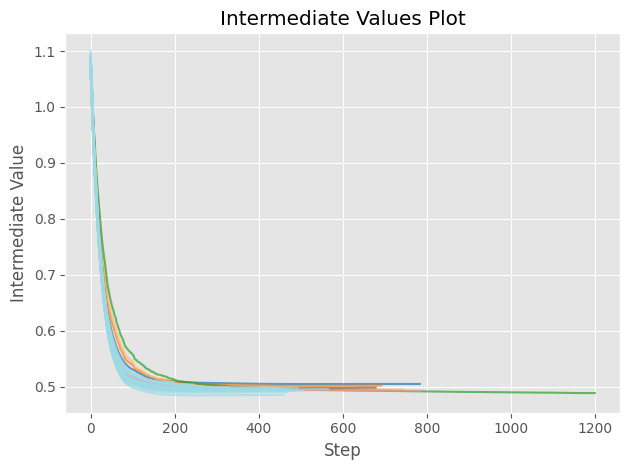

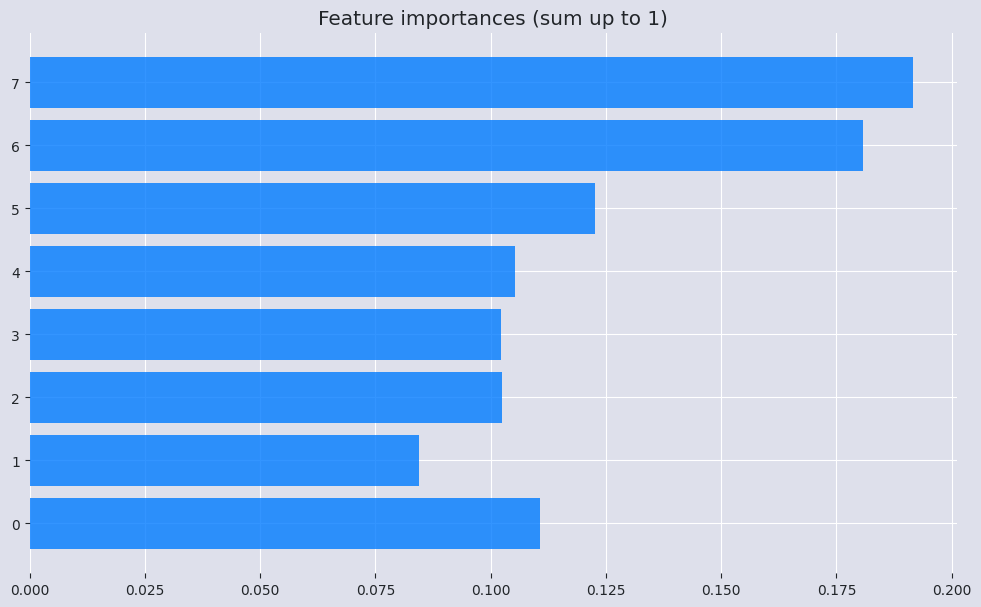


     . Optuna hyperparameters optimization finished
     .. Best trial number:41    |     rmse:            0.484407120162971
 ---------------------------------------------------------------------------
     . n_estimators optimization finished
     .. best iteration:  284   |     rmse:            0.495225226934423

Time elapsed for fit execution: 1 min 52.959 sec

 * Initiating LGBMTuner.fit
     . Settings:
     .. Trying 150 trials
     .. Evaluation metric: rmse 
     .. Study direction: minimize rmse

     . Trial number: 0 finished
     .. Optimization score (lower-better): rmse: 0.4986750613409009
 ...........................................................................
     . Trial number: 1 finished
     .. Optimization score (lower-better): rmse: 0.4945833486096214
 ...........................................................................
     . Trial number: 2 finished
     .. Optimization score (lower-better): rmse: 0.5005863230297076
 .................................

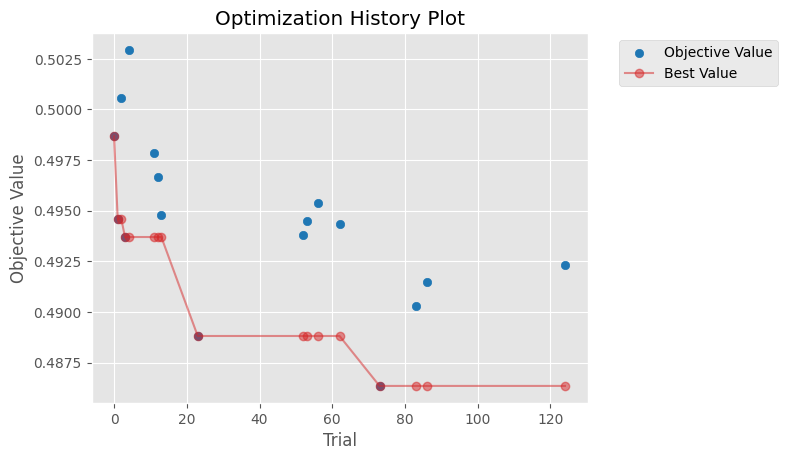

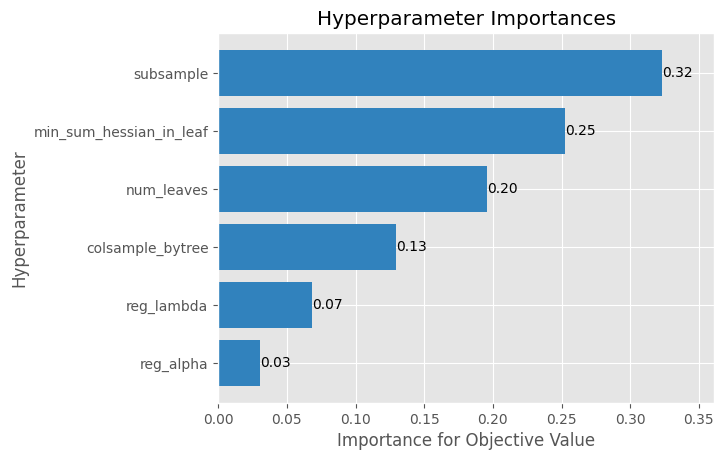

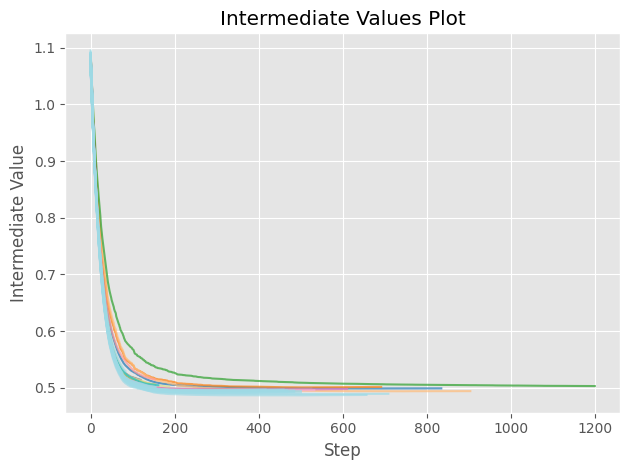

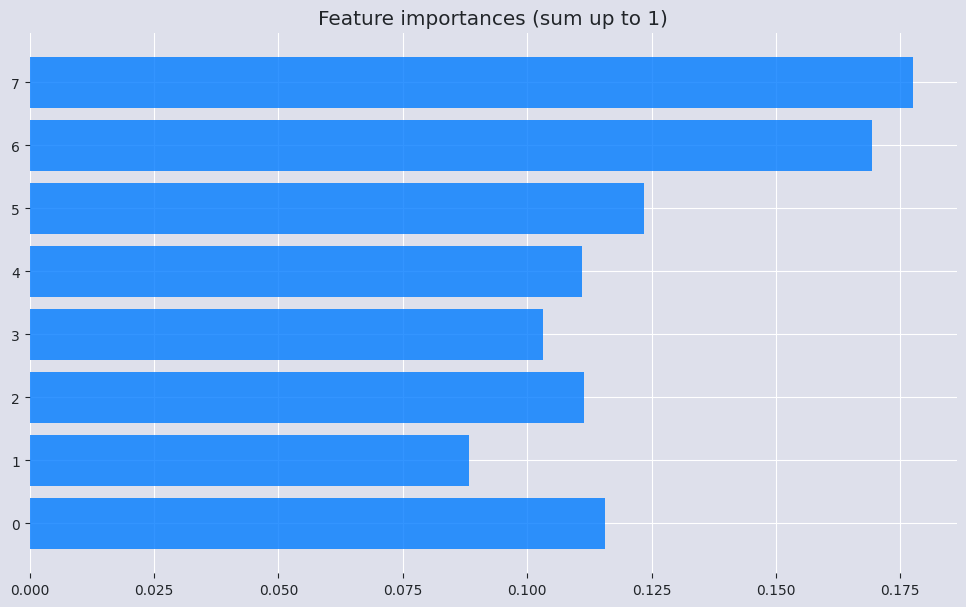


     . Optuna hyperparameters optimization finished
     .. Best trial number:73    |     rmse:           0.4863446390394915
 ---------------------------------------------------------------------------
     . n_estimators optimization finished
     .. best iteration:  444   |     rmse:           0.4941996075918833

Time elapsed for fit execution: 1 min 46.845 sec

 * Initiating LGBMTuner.fit
     . Settings:
     .. Trying 150 trials
     .. Evaluation metric: rmse 
     .. Study direction: minimize rmse

     . Trial number: 0 finished
     .. Optimization score (lower-better): rmse: 0.5012664747229734
 ...........................................................................
     . Trial number: 1 finished
     .. Optimization score (lower-better): rmse: 0.49657027575614704
 ...........................................................................
     . Trial number: 2 finished
     .. Optimization score (lower-better): rmse: 0.5084413659847947
 ................................

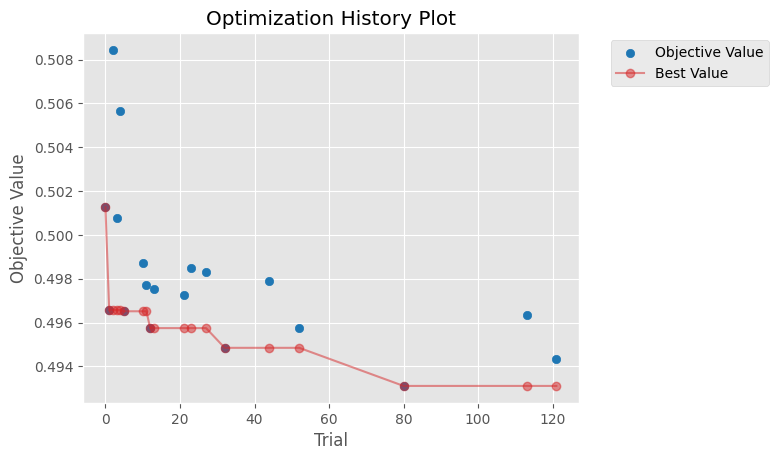

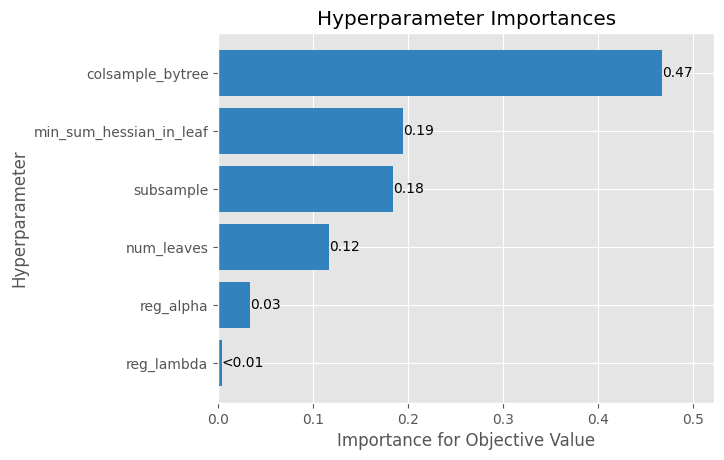

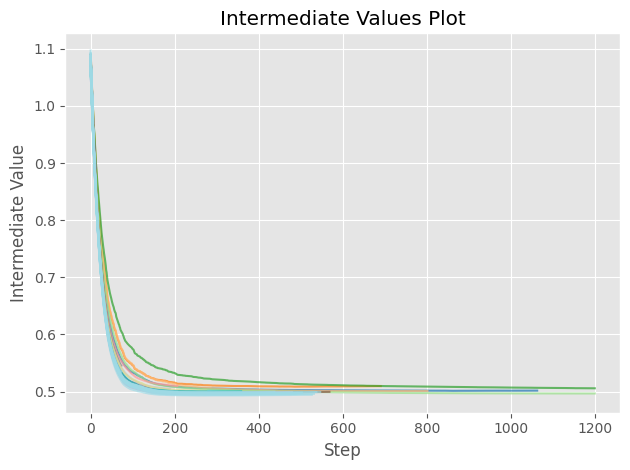

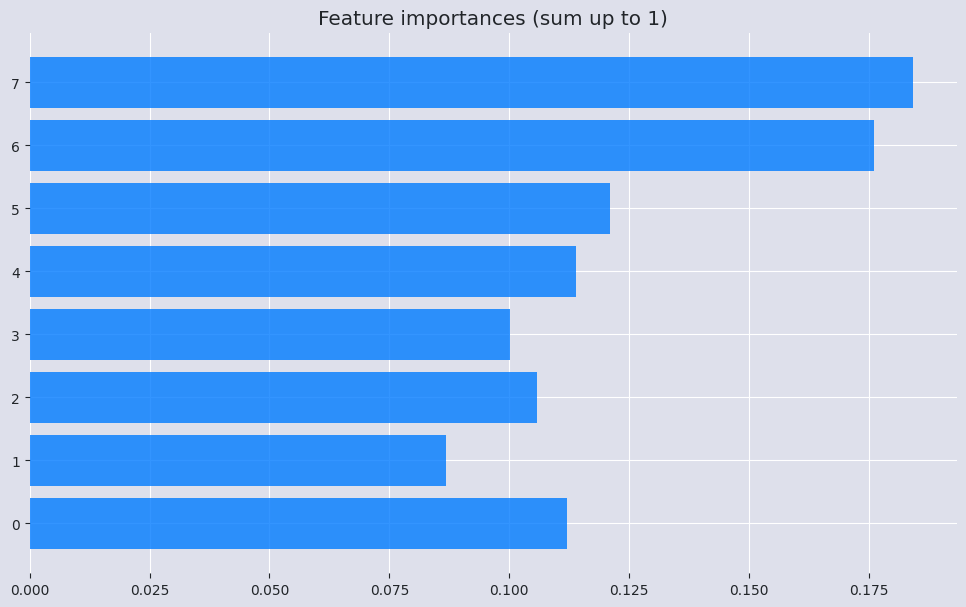


     . Optuna hyperparameters optimization finished
     .. Best trial number:80    |     rmse:          0.49310732571412214
 ---------------------------------------------------------------------------
     . n_estimators optimization finished
     .. best iteration:  301   |     rmse:          0.49485520037311237

Time elapsed for fit execution: 1 min 45.799 sec

 * Initiating LGBMTuner.fit
     . Settings:
     .. Trying 150 trials
     .. Evaluation metric: rmse 
     .. Study direction: minimize rmse

     . Trial number: 0 finished
     .. Optimization score (lower-better): rmse: 0.49507534145492516
 ...........................................................................
     . Trial number: 1 finished
     .. Optimization score (lower-better): rmse: 0.5011000318571643
 ...........................................................................
     . Trial number: 2 finished
     .. Optimization score (lower-better): rmse: 0.5060943003089916
 ................................

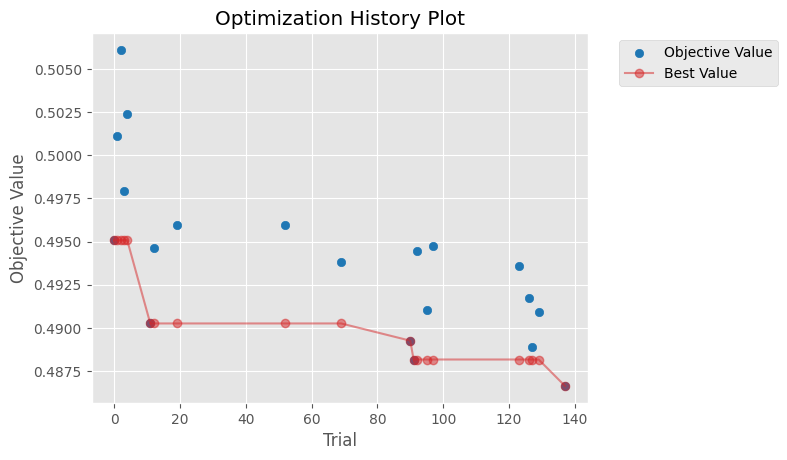

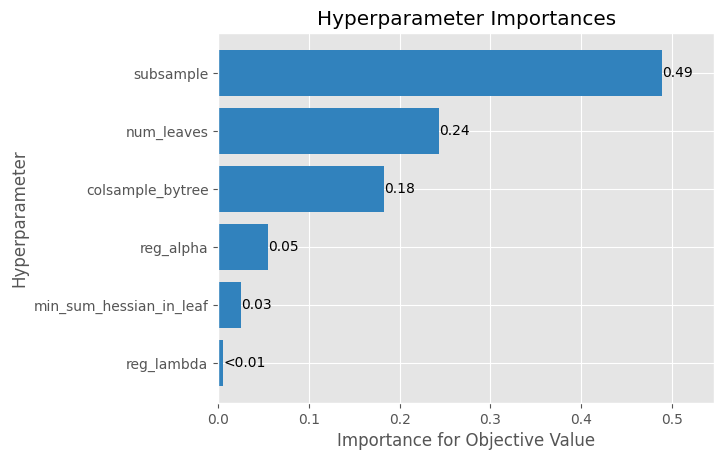

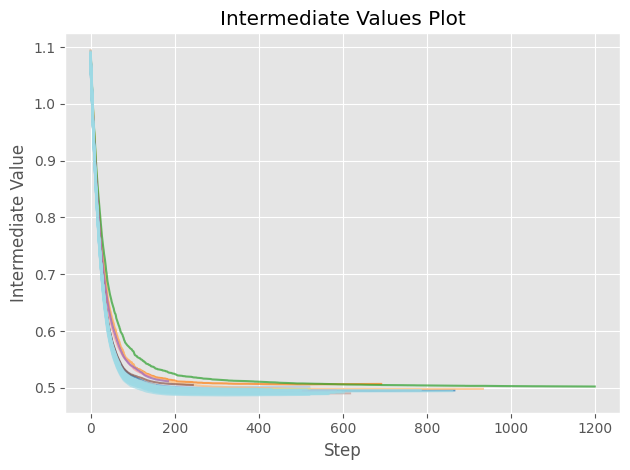

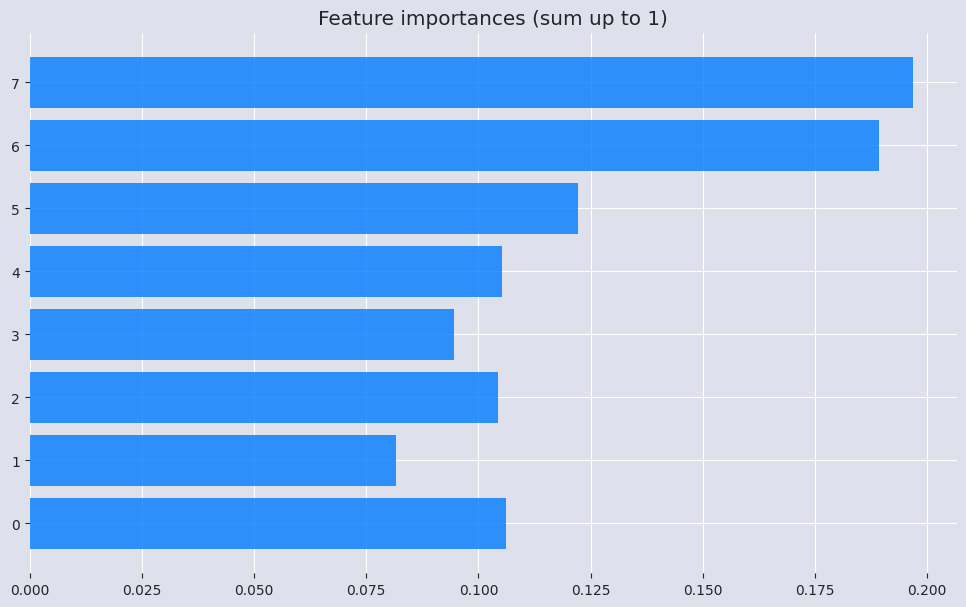


     . Optuna hyperparameters optimization finished
     .. Best trial number:137    |     rmse:          0.48663925891030174
 ---------------------------------------------------------------------------
     . n_estimators optimization finished
     .. best iteration:  295   |     rmse:           0.4982940970344147

Time elapsed for fit execution: 1 min 55.216 sec


In [10]:
Pre = stable_prediction(n_trials=12)